# 1. Import libraries and data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
import optuna
from neuralprophet import NeuralProphet
from neuralprophet import set_random_seed, save, load
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU
import warnings
warnings.filterwarnings("ignore")
set_random_seed(99)

C:\Users\namtrantuan\AppData\Roaming\Python\Python39\site-packages\plotly_resampler\aggregation\aggregators.py:25: UserWarning: Could not import lttbc; will use a (slower) python alternative.
  warnings.warn("Could not import lttbc; will use a (slower) python alternative.")


In [2]:
pd.options.display.float_format = '{:20,.0f}'.format

In [3]:
dom = pd.read_excel('dom.xlsx')
dom = dom.rename(columns={'DATE': 'ds', 'Pax': 'y'})
dom.drop('seat', axis = 1, inplace = True)

In [4]:
dom.head()

,ds,y
0,2015-01-01,"52,356"
1,2015-01-02,"47,811"
2,2015-01-03,"49,555"
3,2015-01-04,"57,680"
4,2015-01-05,"50,193"


In [5]:
dom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3012 entries, 0 to 3011
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      3012 non-null   datetime64[ns]
 1   y       3012 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 47.2 KB


<AxesSubplot:xlabel='ds'>

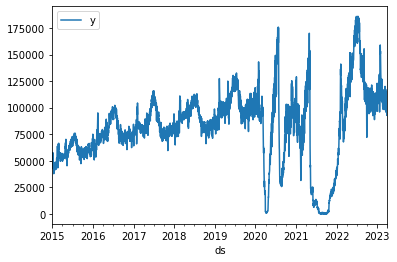

In [6]:
dom.set_index('ds').plot()

In [7]:
holidays = pd.read_excel('holidays2.xlsx')

In [8]:
# changepoints là những mốc bắt đầu và kết thúc của các đợt dịch covid hoặc thay đổi về trend:
changepoints = ['2020-03-09','2020-05-31','2020-07-28','2020-09-30','2021-01-25','2021-03-31','2021-04-30','2021-10-22']

# 2. Build models

## 2.1. Neural prophet

In [9]:
train = dom[dom['ds'] < '2022-07-01'].copy()
val = dom[(dom['ds'] >= '2022-07-01')&(dom['ds'] < '2023-01-01')].copy()
test = dom[dom['ds'] >= '2023-01-01'].copy()

In [10]:
holidays = holidays.rename(columns={'holiday': 'event'})
train_holidays = holidays[holidays['ds'] < '2022-07-01'].copy()
val_holidays = holidays[(holidays['ds'] >= '2022-07-01')&(holidays['ds'] < '2023-01-01')].copy()
test_holidays = holidays[holidays['ds'] >= '2023-01-01'].copy()

In [11]:
def objective(trial):
    set_random_seed(99)
    """Define the objective function"""

    params = {
        'trend_reg': trial.suggest_float('trend_reg',0.001,100),
        'seasonality_reg': trial.suggest_float('seasonality_reg',0.1, 100),
        'seasonality_mode': trial.suggest_categorical('seasonality_mode',['multiplicative', 'additive']),
        'yearly_seasonality':trial.suggest_int('yearly_seasonality',10,40),
        'weekly_seasonality':trial.suggest_int('weekly_seasonality',1,40),
        'n_lags':trial.suggest_int('n_lags',1,365),
        'ar_reg':trial.suggest_float('ar_reg',0,10),
        'learning_rate':trial.suggest_float('learning_rate',0.001,10),
        'num_hidden_layers':trial.suggest_int('num_hidden_layers',0,3),
        'loss_func':trial.suggest_categorical('loss_func',['Huber', 'MAE'])
    }
    events_params_1 = {'regularization':trial.suggest_float('event1_regularization',0,0.2),
                      'mode':trial.suggest_categorical('event1_mode',['multiplicative', 'additive'])}
    events_params_2 = {'regularization':trial.suggest_float('event2_regularization',0,0.2),
                      'mode':trial.suggest_categorical('event2_mode',['multiplicative', 'additive'])}  
    
    # Create the model
    optuna_model = NeuralProphet(**params, changepoints = changepoints, daily_seasonality = False, n_forecasts = 365)
    optuna_model.add_events(events = ['covid_1','covid_2','covid_3','covid_4','No_int'], **events_params_1)  
    optuna_model.add_events(events = ['Lunar','Labor','Summer','new_year'], **events_params_2)
    
    # create the data df with events
    train_df = optuna_model.create_df_with_events(train, train_holidays)
    val_df = optuna_model.create_df_with_events(val, val_holidays)
    
    # Fit the model
    metrics = optuna_model.fit(train_df, freq="D")

    # Make predictions
    future_df = optuna_model.make_future_dataframe(train_df, events_df=holidays)
    optuna_forecast = optuna_model.predict(df=future_df)
    latest = optuna_model.get_latest_forecast(optuna_forecast)

    # Evaluate prediction
    result = val_df.merge(latest,how = 'left', on = 'ds')
    result.set_index('ds', inplace = True)
    rmse = np.sqrt(mean_squared_error(result['y_x'], result['origin-0'])).round(0)
    return rmse

In [12]:
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=99))

[I 2023-04-25 15:34:27,601] A new study created in memory with name: no-name-8f349bb7-af70-46d7-b476-215e3234196a


In [ ]:
study.optimize(objective, n_trials=300)

INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 152


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.789% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.789% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 71it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 15:37:15,870] Trial 0 finished with value: 41781.0 and parameters: {'trend_reg': 67.22818358452055, 'seasonality_reg': 48.85903208413432, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 35, 'weekly_seasonality': 23, 'n_lags': 109, 'ar_reg': 0.46695720506953253, 'learning_rate': 9.906283367308491, 'num_hidden_layers': 0, 'loss_func': 'Huber', 'event1_regularization': 0.07548778726699304, 'event1_mode': 'additive', 'event2_regularization': 0.07909080886916407, 'event2_mode': 'multiplicative'}. Best is trial 0 with value: 41781.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
W

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.85% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.85% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 65it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 15:39:54,164] Trial 1 finished with value: 120206.0 and parameters: {'trend_reg': 9.362215716681959, 'seasonality_reg': 81.34951043693468, 'seasonality_mode': 'additive', 'yearly_seasonality': 19, 'weekly_seasonality': 33, 'n_lags': 303, 'ar_reg': 2.215773717295777, 'learning_rate': 6.448702181331513, 'num_hidden_layers': 0, 'loss_func': 'Huber', 'event1_regularization': 0.028802199781536933, 'event1_mode': 'additive', 'event2_regularization': 0.015522767320002974, 'event2_mode': 'multiplicative'}. Best is trial 0 with value: 41781.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNIN

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.82% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.82% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 15:42:42,665] Trial 2 finished with value: 38124.0 and parameters: {'trend_reg': 89.86452006305291, 'seasonality_reg': 55.26821924507856, 'seasonality_mode': 'additive', 'yearly_seasonality': 26, 'weekly_seasonality': 2, 'n_lags': 192, 'ar_reg': 6.401425405143248, 'learning_rate': 8.00678097830046, 'num_hidden_layers': 3, 'loss_func': 'MAE', 'event1_regularization': 0.09324762694196845, 'event1_mode': 'additive', 'event2_regularization': 0.07546675744907937, 'event2_mode': 'additive'}. Best is trial 2 with value: 38124.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forec

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.806% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.806% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 15:46:19,471] Trial 3 finished with value: 67880.0 and parameters: {'trend_reg': 93.91780311110828, 'seasonality_reg': 83.76560989826794, 'seasonality_mode': 'additive', 'yearly_seasonality': 36, 'weekly_seasonality': 4, 'n_lags': 150, 'ar_reg': 6.415701007734636, 'learning_rate': 9.764536770846385, 'num_hidden_layers': 2, 'loss_func': 'Huber', 'event1_regularization': 0.05861302258677808, 'event1_mode': 'additive', 'event2_regularization': 0.1437012759555653, 'event2_mode': 'multiplicative'}. Best is trial 2 with value: 38124.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.762% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.762% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 73it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 15:50:41,009] Trial 4 finished with value: 47600.0 and parameters: {'trend_reg': 31.260133180501843, 'seasonality_reg': 4.986377428906286, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 35, 'weekly_seasonality': 37, 'n_lags': 56, 'ar_reg': 4.700286207548979, 'learning_rate': 5.463140085069839, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04705330788557452, 'event1_mode': 'additive', 'event2_regularization': 0.04873126080603332, 'event2_mode': 'multiplicative'}. Best is trial 2 with value: 38124.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNI

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.823% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.823% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 15:53:22,048] Trial 5 finished with value: 62948.0 and parameters: {'trend_reg': 69.103296834964, 'seasonality_reg': 35.544821127851655, 'seasonality_mode': 'additive', 'yearly_seasonality': 15, 'weekly_seasonality': 10, 'n_lags': 199, 'ar_reg': 3.5491121674008, 'learning_rate': 7.4467278727058765, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.10531726780819961, 'event1_mode': 'additive', 'event2_regularization': 0.021324673976366528, 'event2_mode': 'multiplicative'}. Best is trial 2 with value: 38124.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (N

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.841% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.841% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 15:55:51,594] Trial 6 finished with value: 146677.0 and parameters: {'trend_reg': 50.70844456824804, 'seasonality_reg': 80.70697372251932, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 20, 'weekly_seasonality': 4, 'n_lags': 265, 'ar_reg': 7.513537114521935, 'learning_rate': 6.150779062696199, 'num_hidden_layers': 3, 'loss_func': 'MAE', 'event1_regularization': 0.16964653710656954, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1545161040649919, 'event2_mode': 'multiplicative'}. Best is trial 2 with value: 38124.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.83% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.83% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 15:58:51,199] Trial 7 finished with value: 50917.0 and parameters: {'trend_reg': 68.9534708091899, 'seasonality_reg': 24.988820481837102, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 29, 'weekly_seasonality': 25, 'n_lags': 223, 'ar_reg': 7.030933274614392, 'learning_rate': 0.7698121462569356, 'num_hidden_layers': 0, 'loss_func': 'MAE', 'event1_regularization': 0.13152312881814884, 'event1_mode': 'additive', 'event2_regularization': 0.16821258028351935, 'event2_mode': 'multiplicative'}. Best is trial 2 with value: 38124.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARN

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.761% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.761% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 73it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 16:03:10,576] Trial 8 finished with value: 32780.0 and parameters: {'trend_reg': 94.75551283222595, 'seasonality_reg': 23.252949089536482, 'seasonality_mode': 'additive', 'yearly_seasonality': 11, 'weekly_seasonality': 32, 'n_lags': 53, 'ar_reg': 0.8649102197078118, 'learning_rate': 8.189965889533655, 'num_hidden_layers': 3, 'loss_func': 'MAE', 'event1_regularization': 0.18737720663589708, 'event1_mode': 'multiplicative', 'event2_regularization': 0.14145658079252127, 'event2_mode': 'additive'}. Best is trial 8 with value: 32780.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.842% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.842% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 16:08:05,488] Trial 9 finished with value: 31944.0 and parameters: {'trend_reg': 71.31326582278776, 'seasonality_reg': 71.52906292230175, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 25, 'weekly_seasonality': 38, 'n_lags': 269, 'ar_reg': 1.6447437009756782, 'learning_rate': 0.6660012473263757, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04846931473930989, 'event1_mode': 'additive', 'event2_regularization': 0.031720665408139295, 'event2_mode': 'additive'}. Best is trial 9 with value: 31944.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.863% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.863% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 63it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 16:12:29,460] Trial 10 finished with value: 17754.0 and parameters: {'trend_reg': 33.74158671683395, 'seasonality_reg': 61.59187591533609, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 30, 'weekly_seasonality': 40, 'n_lags': 365, 'ar_reg': 2.8427833740002195, 'learning_rate': 0.34793658931291116, 'num_hidden_layers': 1, 'loss_func': 'Huber', 'event1_regularization': 0.008124477189068537, 'event1_mode': 'multiplicative', 'event2_regularization': 0.10601485615663699, 'event2_mode': 'additive'}. Best is trial 10 with value: 17754.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colu

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.863% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.863% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 63it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 16:16:02,782] Trial 11 finished with value: 53295.0 and parameters: {'trend_reg': 26.185353056391456, 'seasonality_reg': 61.27236174947568, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 30, 'weekly_seasonality': 38, 'n_lags': 365, 'ar_reg': 9.828700985903964, 'learning_rate': 0.1538372328891947, 'num_hidden_layers': 1, 'loss_func': 'Huber', 'event1_regularization': 0.010987509665710805, 'event1_mode': 'multiplicative', 'event2_regularization': 0.11136280404881041, 'event2_mode': 'additive'}. Best is trial 10 with value: 17754.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colum

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.862% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.862% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 63it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 16:18:55,696] Trial 12 finished with value: 15470.0 and parameters: {'trend_reg': 45.12190165078739, 'seasonality_reg': 99.77232465798588, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 23, 'weekly_seasonality': 30, 'n_lags': 358, 'ar_reg': 2.7193032660527474, 'learning_rate': 2.688742419054353, 'num_hidden_layers': 1, 'loss_func': 'Huber', 'event1_regularization': 0.0018828693336962275, 'event1_mode': 'multiplicative', 'event2_regularization': 0.19462179002378102, 'event2_mode': 'additive'}. Best is trial 12 with value: 15470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colum

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.862% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.862% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 63it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 16:22:01,529] Trial 13 finished with value: 16086.0 and parameters: {'trend_reg': 37.29710535208028, 'seasonality_reg': 98.54122803353296, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 40, 'weekly_seasonality': 29, 'n_lags': 361, 'ar_reg': 3.1393711094477856, 'learning_rate': 3.286501111364959, 'num_hidden_layers': 1, 'loss_func': 'Huber', 'event1_regularization': 0.0009104492776905587, 'event1_mode': 'multiplicative', 'event2_regularization': 0.19049640005704796, 'event2_mode': 'additive'}. Best is trial 12 with value: 15470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colum

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.853% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.853% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 65it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 16:25:34,166] Trial 14 finished with value: 15679.0 and parameters: {'trend_reg': 46.75671085719201, 'seasonality_reg': 99.48789562850142, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 40, 'weekly_seasonality': 29, 'n_lags': 316, 'ar_reg': 3.9798187210065397, 'learning_rate': 3.1657348701294348, 'num_hidden_layers': 1, 'loss_func': 'Huber', 'event1_regularization': 0.0033611997935397817, 'event1_mode': 'multiplicative', 'event2_regularization': 0.18124176708792927, 'event2_mode': 'additive'}. Best is trial 12 with value: 15470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colu

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.851% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.851% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 65it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 16:28:30,574] Trial 15 finished with value: 23085.0 and parameters: {'trend_reg': 50.90519520129375, 'seasonality_reg': 99.44709749008177, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 20, 'weekly_seasonality': 21, 'n_lags': 304, 'ar_reg': 4.866093731012793, 'learning_rate': 3.4935056371293722, 'num_hidden_layers': 1, 'loss_func': 'Huber', 'event1_regularization': 0.03480902163972837, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1893031591703921, 'event2_mode': 'additive'}. Best is trial 12 with value: 15470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
W

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.853% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.853% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 65it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 16:31:17,259] Trial 16 finished with value: 44657.0 and parameters: {'trend_reg': 10.921968329199338, 'seasonality_reg': 87.82418839348465, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 25, 'weekly_seasonality': 17, 'n_lags': 316, 'ar_reg': 4.143617806504593, 'learning_rate': 3.1522881974759764, 'num_hidden_layers': 1, 'loss_func': 'Huber', 'event1_regularization': 0.12698254392810995, 'event1_mode': 'multiplicative', 'event2_regularization': 0.19975724219594906, 'event2_mode': 'additive'}. Best is trial 12 with value: 15470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.837% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.837% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 16:33:36,845] Trial 17 finished with value: 65284.0 and parameters: {'trend_reg': 57.5362081346305, 'seasonality_reg': 91.8041508096951, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 22, 'weekly_seasonality': 16, 'n_lags': 249, 'ar_reg': 5.505856095638787, 'learning_rate': 2.471509894460563, 'num_hidden_layers': 0, 'loss_func': 'Huber', 'event1_regularization': 0.02376498105293466, 'event1_mode': 'multiplicative', 'event2_regularization': 0.12368261708130701, 'event2_mode': 'additive'}. Best is trial 12 with value: 15470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WAR

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.732% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.732% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 74it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 16:36:47,000] Trial 18 finished with value: 30595.0 and parameters: {'trend_reg': 20.340398086179825, 'seasonality_reg': 70.0441695534613, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 40, 'weekly_seasonality': 27, 'n_lags': 8, 'ar_reg': 1.6144466708447451, 'learning_rate': 1.7806425040343736, 'num_hidden_layers': 1, 'loss_func': 'Huber', 'event1_regularization': 0.07593923243099203, 'event1_mode': 'multiplicative', 'event2_regularization': 0.17108919545477333, 'event2_mode': 'additive'}. Best is trial 12 with value: 15470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
W

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.854% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.854% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 65it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 16:39:38,062] Trial 19 finished with value: 24095.0 and parameters: {'trend_reg': 41.946013986224784, 'seasonality_reg': 73.24841554191774, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 15, 'weekly_seasonality': 30, 'n_lags': 322, 'ar_reg': 8.577592391695315, 'learning_rate': 4.326378721877546, 'num_hidden_layers': 2, 'loss_func': 'Huber', 'event1_regularization': 0.06643440647133814, 'event1_mode': 'multiplicative', 'event2_regularization': 0.17108371799736866, 'event2_mode': 'additive'}. Best is trial 12 with value: 15470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.804% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.804% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 16:42:34,604] Trial 20 finished with value: 26316.0 and parameters: {'trend_reg': 78.59869686280095, 'seasonality_reg': 41.00518052506988, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 33, 'weekly_seasonality': 17, 'n_lags': 145, 'ar_reg': 3.7613094035386814, 'learning_rate': 1.7738909235362859, 'num_hidden_layers': 0, 'loss_func': 'Huber', 'event1_regularization': 0.023108409749455723, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1295528866032248, 'event2_mode': 'additive'}. Best is trial 12 with value: 15470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.858% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.858% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 64it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 16:46:34,146] Trial 21 finished with value: 15576.0 and parameters: {'trend_reg': 41.502293789111505, 'seasonality_reg': 98.67854105157876, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 40, 'weekly_seasonality': 29, 'n_lags': 341, 'ar_reg': 2.7851941637466266, 'learning_rate': 4.320743231829304, 'num_hidden_layers': 1, 'loss_func': 'Huber', 'event1_regularization': 0.0015805490619240693, 'event1_mode': 'multiplicative', 'event2_regularization': 0.18396705277083109, 'event2_mode': 'additive'}. Best is trial 12 with value: 15470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colu

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.855% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.855% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 64it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 16:50:05,102] Trial 22 finished with value: 15956.0 and parameters: {'trend_reg': 44.30028396446876, 'seasonality_reg': 94.77957424492605, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 38, 'weekly_seasonality': 35, 'n_lags': 327, 'ar_reg': 2.011242762242216, 'learning_rate': 4.634404471248256, 'num_hidden_layers': 1, 'loss_func': 'Huber', 'event1_regularization': 0.0012296664653713937, 'event1_mode': 'multiplicative', 'event2_regularization': 0.17782680963736197, 'event2_mode': 'additive'}. Best is trial 12 with value: 15470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.846% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.846% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 16:53:08,203] Trial 23 finished with value: 21130.0 and parameters: {'trend_reg': 58.20653906756026, 'seasonality_reg': 90.37263033668373, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 32, 'weekly_seasonality': 27, 'n_lags': 286, 'ar_reg': 2.7615305515731223, 'learning_rate': 4.3024983517059825, 'num_hidden_layers': 1, 'loss_func': 'Huber', 'event1_regularization': 0.03864504652686204, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15880176414975627, 'event2_mode': 'additive'}. Best is trial 12 with value: 15470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.859% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.859% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 64it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 16:56:19,654] Trial 24 finished with value: 20886.0 and parameters: {'trend_reg': 18.84973945146696, 'seasonality_reg': 98.75702034488059, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 38, 'weekly_seasonality': 33, 'n_lags': 343, 'ar_reg': 5.675000488674873, 'learning_rate': 1.9297349980622853, 'num_hidden_layers': 1, 'loss_func': 'Huber', 'event1_regularization': 0.018697793705709124, 'event1_mode': 'multiplicative', 'event2_regularization': 0.19623143687214653, 'event2_mode': 'additive'}. Best is trial 12 with value: 15470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.835% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.835% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 17:00:52,355] Trial 25 finished with value: 15962.0 and parameters: {'trend_reg': 58.2697676668589, 'seasonality_reg': 74.99357807703862, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 28, 'weekly_seasonality': 23, 'n_lags': 240, 'ar_reg': 0.015517462942853832, 'learning_rate': 3.6968513421259974, 'num_hidden_layers': 2, 'loss_func': 'Huber', 'event1_regularization': 0.00012136522743145888, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15261122008878195, 'event2_mode': 'additive'}. Best is trial 12 with value: 15470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID co

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.858% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.858% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 64it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 17:06:00,377] Trial 26 finished with value: 72905.0 and parameters: {'trend_reg': 43.37953993889832, 'seasonality_reg': 86.51906016068904, 'seasonality_mode': 'additive', 'yearly_seasonality': 23, 'weekly_seasonality': 30, 'n_lags': 338, 'ar_reg': 4.055651194641908, 'learning_rate': 2.570206412853679, 'num_hidden_layers': 1, 'loss_func': 'Huber', 'event1_regularization': 0.04440931723209775, 'event1_mode': 'multiplicative', 'event2_regularization': 0.18207818363879977, 'event2_mode': 'additive'}. Best is trial 12 with value: 15470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.847% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.847% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 17:10:25,209] Trial 27 finished with value: 45570.0 and parameters: {'trend_reg': 1.2236446206681322, 'seasonality_reg': 91.67529627121365, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 33, 'weekly_seasonality': 27, 'n_lags': 287, 'ar_reg': 2.3562147946901564, 'learning_rate': 5.561622137772644, 'num_hidden_layers': 0, 'loss_func': 'Huber', 'event1_regularization': 0.018103187502249336, 'event1_mode': 'multiplicative', 'event2_regularization': 0.08513284025199382, 'event2_mode': 'additive'}. Best is trial 12 with value: 15470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colum

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.829% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.829% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 17:14:50,317] Trial 28 finished with value: 43641.0 and parameters: {'trend_reg': 27.379273516467173, 'seasonality_reg': 80.53003402510934, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 37, 'weekly_seasonality': 20, 'n_lags': 220, 'ar_reg': 1.1045966478870501, 'learning_rate': 1.342842249214341, 'num_hidden_layers': 1, 'loss_func': 'Huber', 'event1_regularization': 0.14966712418785194, 'event1_mode': 'multiplicative', 'event2_regularization': 0.13223503870368325, 'event2_mode': 'additive'}. Best is trial 12 with value: 15470.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

In [ ]:
params = study.best_trial.params
# params =  {'trend_reg': 75.1356197915079, 'seasonality_reg': 61.54243708004303, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 16, 'weekly_seasonality': 34, 'n_lags': 483, 'ar_reg': 5.164365326761173, 'learning_rate': 7.72603262272927, 'num_hidden_layers': 3, 'loss_func': 'MAE', 'event1_regularization': 0.04982746843210631, 'event1_mode': 'multiplicative', 'event2_regularization': 0.12358177987389328, 'event2_mode': 'additive', 'lagged_regularization': 0.5624746619691513, 'lagged_normalize': False, 'lagged_n_lags': 706}

In [ ]:
events_params_1 = {key: params[key] for key in ['event1_regularization','event1_mode']}
events_params_2 = {key: params[key] for key in ['event2_regularization','event2_mode']}
main_params = {key: params[key] for key in ['trend_reg','seasonality_reg','seasonality_mode',
                                            'yearly_seasonality','n_lags','ar_reg','learning_rate','num_hidden_layers','loss_func']}

In [ ]:
events_params_1 = dict(zip(['regularization','mode'], list(events_params_1.values())))
events_params_2 = dict(zip(['regularization','mode'], list(events_params_2.values())))

In [ ]:
set_random_seed(99)

In [ ]:
m = NeuralProphet(**main_params, changepoints = changepoints, daily_seasonality = False, n_forecasts = 365)
m.add_events(events = ['covid_1','covid_2','covid_3','covid_4','No_int'], **events_params_1)
m.add_events(events = ['Labor','Lunar','Summer','new_year'], **events_params_2)

# create the data df with events
train_df = m.create_df_with_events(train, train_holidays)
val_df = m.create_df_with_events(val, val_holidays)
train_val_df = pd.concat([train_df,val_df])
test_df = m.create_df_with_events(test, test_holidays)

In [ ]:
metrics = m.fit(train_val_df,
                freq="D",
                progress="plot")

In [ ]:
fig_param = m.plot_parameters()

In [ ]:
future = m.make_future_dataframe(train_val_df, n_historic_predictions=True, events_df=holidays)

In [ ]:
future[(future['ds']>='2023-01-01')&(future['ds']<'2023-12-31')]

In [ ]:
forecast = m.predict(future, decompose = True)
fig = m.plot(forecast)

In [ ]:
#Consolidate forecast result
for i in forecast.filter(regex= ('yhat')).columns[1:]:
    forecast['yhat1'].update(forecast.pop(i))
for i in forecast.filter(regex= ('ar\d')).columns[1:]:
    forecast['ar1'].update(forecast.pop(i))

In [ ]:
forecast.update(forecast[['ds','yhat1']].merge(dom, 'left','ds'))

In [ ]:
forecast

In [ ]:
forecast.to_excel('forecast.xlsx')